In [1]:
import pandas as pd
import numpy as np

OMDB Database Cleaning

In [2]:
omdb = pd.read_csv('../../data/raw/omdb_total.csv')
movies = pd.read_csv('../../data/preprocessed/movies_id_updated.csv')

In [3]:
movies.loc[5019]

id                                                             5342
title                                                        Nomads
imdbID                                                    tt0720339
spanishTitle                                                 Nomads
imdbPictureURL    http://ia.media-imdb.com/images/M/MV5BMTI2Nzc3...
year                                                           2001
rtID                                                            NaN
rtPictureURL                                                     \N
Name: 5019, dtype: object

In [4]:
#Delete movie 'nomads' (no information)
movies = movies.drop(5019)

In [5]:
omdb.shape

(10192, 32)

In [6]:
# delete unwanted columns
omdb = omdb.drop(columns={'Unnamed: 0', 'Response'})
# delete sparse or unimportant columns
omdb = omdb.drop(columns={'Production', 'Website', 'Season', 'Episode', 'seriesID', 'Type', 'BoxOffice', 'DVD', 'Poster'})
# delete duplicate ratings
omdb = omdb.drop(columns={'Internet Movie Database', 'Metascore'})

In [7]:
omdb.head(1)

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,imdbRating,imdbVotes,imdbID,Rotten Tomatoes,Metacritic,totalSeasons
0,Toy Story,1995,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",A cowboy doll is profoundly threatened and jea...,English,USA,Nominated for 3 Oscars. Another 27 wins & 20 n...,8.3,"852,896",tt0114709,100%,95/100,NaN


In [8]:
# delete duplicates as we retrieved the omdb data based on the movieID which contained duplicates
omdb.duplicated('imdbID').sum()

774

In [9]:
omdb = omdb.drop_duplicates('imdbID')

In [10]:
# 5 movies of the movies.csv are not available :/
omdb.shape

(9418, 19)

Series or film

In [11]:
omdb['Series']=omdb['totalSeasons'].notna().replace({True: 1, False: 0})
omdb=omdb.drop(columns={'totalSeasons'})

Ratings and votes

In [12]:
# convert ratings of other databases to float and into the same format as imdbRating
omdb['Rotten Tomatoes'] = omdb['Rotten Tomatoes'].str.replace(r'\D', '').astype(float)/10
omdb['Metacritic'] = omdb['Metacritic'].str.replace(r'/100', '').astype(float)/10

In [13]:
# convert imdbVotes to float format
omdb['imdbVotes'] = omdb['imdbVotes'].astype(str).apply(lambda x: x.replace(",","")).astype(float)

Runtime

In [14]:
# convert runtime into float, unit: min
omdb['Runtime'] = omdb['Runtime'].str.replace(r'min', '').astype(float)

Release date

In [15]:
# select the season
# in order to compare spring(march,april,may)=2, summer(june,july,august)=3, fall(september,october,november)=4 & winter(december, january, february)=1
season_dic = {1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}
omdb['Released_season'] = pd.to_datetime(omdb['Released']).dt.month.replace(season_dic)

In [16]:
# select the month of release
omdb['Released_month'] = pd.to_datetime(omdb['Released']).dt.month

In [17]:
# select the day of release
omdb['Released_day'] = pd.to_datetime(omdb['Released']).dt.day

In [18]:
omdb = omdb.drop(columns={'Released'})

In [19]:
# convert year into float format
# for Series - choose starting date
omdb['Year'] = omdb['Year'].astype(str).apply(lambda x: x[:4]).astype(float)

Movie parental guideline ratings

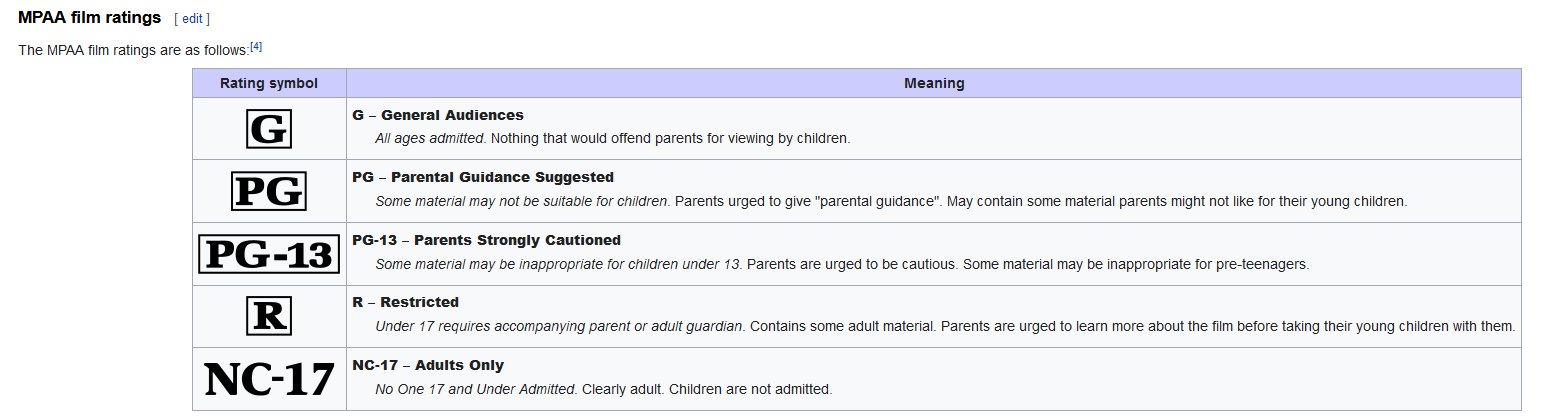

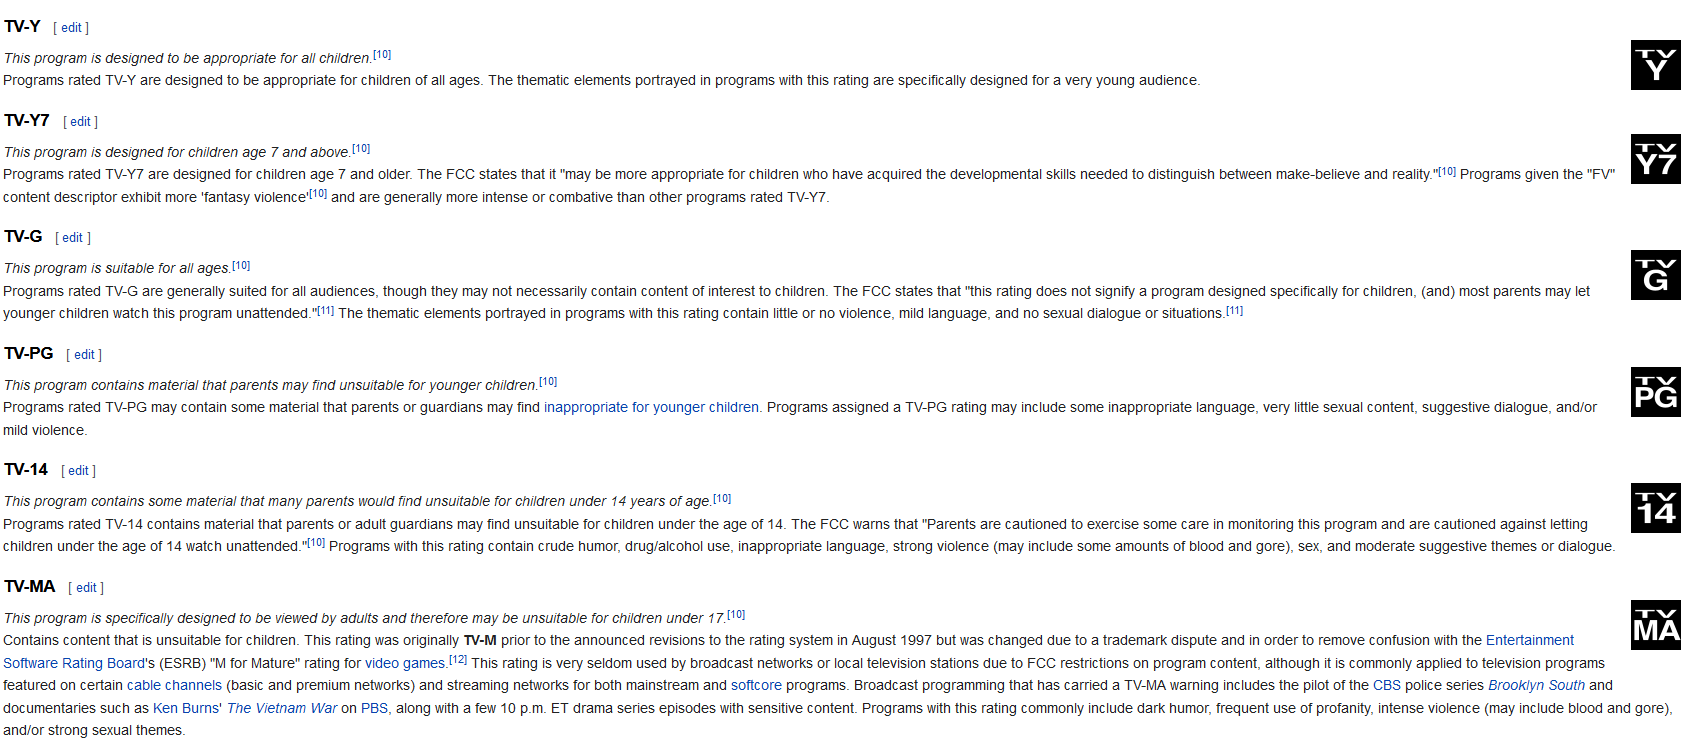

In [20]:
# clean typos and convert all parental-guideline ratings into a scale from 0 - 4 according to suitedness for children
rated_dic = {'R': 3, 'PG-13': 2, 'PG': 1, 'Not Rated': np.NaN, 'nan': np.NaN, 'Approved': np.NaN, 'G': 0, 'Passed': np.NaN, 'Unrated': np.NaN, '14': 2, 'GP': 1, 'NC-17': 4, 'NOT RATED': np.NaN, 'APPROVED': np.NaN, 'MA': 4, 'UNRATED': np.NaN, 'PASSED': np.NaN, 'M': np.NaN, 'M/PG': np.NaN, 'X': np.NaN, 'Y7': 0}
omdb['PG_Rating'] = omdb['Rated'].astype(str).apply(lambda x: x.replace("TV-","")).replace(rated_dic)

Movie Awards

In [21]:
# read out number of oscar and golden globe nominations/wins according to string position and save in one column each
omdb['Awards']

0        Nominated for 3 Oscars. Another 27 wins & 20 n...
1                                 4 wins & 11 nominations.
2                                    1 win & 1 nomination.
3                                 9 wins & 10 nominations.
4        Nominated for 1 Golden Globe. Another 1 win & ...
                               ...                        
10186                              3 wins & 5 nominations.
10187                                                  NaN
10188                              2 wins & 7 nominations.
10190                                        1 nomination.
10191                                                  NaN
Name: Awards, Length: 9418, dtype: object

In [22]:
def oscar_won(x):
    if x[6:11] == 'Oscar':
        return x[4:5]
    else:
        return np.NaN

In [23]:
def oscar_nominated(x):
    if x[16:21] == 'Oscar':
        return x[14:15]
    else:
        return np.NaN

In [24]:
def golden_globe_won(x):
    if x[6:12] == 'Golden':
        return x[4:5]
    else:
        return np.NaN

In [25]:
def golden_globe_nominated(x):
    if x[16:22] == 'Golden':
        return x[14:15]
    else:
        return np.NaN

In [26]:
# filter out number of major movie awards won
omdb['Oscars_won'] = omdb['Awards'].astype(str).apply(oscar_won).astype(float).fillna(0)
omdb['Oscars_nominated'] = omdb['Awards'].astype(str).apply(oscar_nominated).astype(float).fillna(0)
omdb['Golden_globe_won'] = omdb['Awards'].astype(str).apply(golden_globe_won).astype(float).fillna(0)
omdb['Golden_globe_nominated'] = omdb['Awards'].astype(str).apply(golden_globe_nominated).astype(float).fillna(0)
omdb = omdb.drop(columns={'Awards'})

Save the preprocessed omdb file

In [27]:
omdb_relevant = omdb.drop(columns={'Genre', 'Director', 'Actors', 'Country'})

In [28]:
omdb_relevant

,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,imdbVotes,imdbID,...,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,Toy Story,1995.0,G,81.0,"John Lasseter (original story by), Pete Docter...",A cowboy doll is profoundly threatened and jea...,English,8.3,852896.0,tt0114709,...,9.5,0,4.0,11.0,22.0,0.0,0.0,3.0,0.0,0.0
1,Jumanji,1995.0,PG,104.0,"Jonathan Hensleigh (screenplay by), Greg Taylo...",When two kids find and play a magical board ga...,"English, French",7.0,294340.0,tt0113497,...,3.9,0,1.0,12.0,15.0,1.0,0.0,0.0,0.0,0.0
2,Grumpy Old Men,1993.0,PG-13,103.0,Mark Steven Johnson,A lifelong feud between two neighbors since ch...,English,7.0,41401.0,tt0107050,...,5.3,0,1.0,12.0,25.0,2.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,1995.0,R,124.0,"Terry McMillan (novel), Terry McMillan (screen...","Based on Terry McMillan's novel, this film fol...",English,5.9,9222.0,tt0114885,...,NaN,0,1.0,12.0,22.0,3.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,1995.0,PG,106.0,"Albert Hackett (screenplay ""Father's Little Di...",George Banks must deal not only with the pregn...,English,6.0,33005.0,tt0113041,...,4.9,0,1.0,12.0,8.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10186,Bedtime Stories,2008.0,PG,99.0,"Matt Lopez (screenplay), Tim Herlihy (screenpl...",A hotel handyman's life changes when the lavis...,English,6.0,86128.0,tt0960731,...,3.3,0,1.0,12.0,25.0,1.0,0.0,0.0,0.0,0.0
10187,Manhattan Melodrama,1934.0,NOT RATED,93.0,"Oliver H.P. Garrett (screen play), Joseph L. M...",The friendship between two orphans endures eve...,English,7.2,3084.0,tt0025464,...,NaN,0,2.0,5.0,4.0,NaN,0.0,0.0,0.0,0.0
10188,Choke,2008.0,R,92.0,"Clark Gregg (screenplay), Chuck Palahniuk (novel)",A sex-addicted con-man pays for his mother's h...,English,6.4,31058.0,tt1024715,...,4.7,0,4.0,9.0,26.0,3.0,0.0,0.0,0.0,0.0
10190,Blackadder Back & Forth,1999.0,NaN,33.0,"Richard Curtis, Ben Elton","At a New Millennium Eve party, Blackadder and ...",English,7.7,13510.0,tt0212579,...,NaN,0,1.0,12.0,6.0,NaN,0.0,0.0,0.0,0.0


In [29]:
# Add movies which could not be retrieved by omdb
imdb_ids = pd.DataFrame(movies['imdbID'].unique()).rename(columns={0: 'imdbID'})
test = imdb_ids.merge(omdb, how='left', on='imdbID')

In [30]:
movies_raw = pd.read_csv('../../data/raw/movies.csv')

In [31]:
movies_raw[movies_raw['imdbID']== 720339]

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtPictureURL
5019,5342,Nomads,720339,Nomads,http://ia.media-imdb.com/images/M/MV5BMTI2Nzc3...,2001.0,NaN,\N


In [32]:
ratings = pd.read_csv('../../data/raw/ratings.csv', sep=',')
mapping = movies[['id', 'imdbID']].rename(columns={'id':'movieID'})

ratings_imdb = ratings.merge(mapping, how='left', on='movieID')

In [33]:
imdb_ratings = pd.DataFrame(ratings_imdb['imdbID'].unique())

In [34]:
omdb_final = imdb_ratings.merge(omdb_relevant, how='left', left_on=0, right_on='imdbID')
omdb_final

,0,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,imdbVotes,...,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,tt0047034,Godzilla,1954.0,Not Rated,96.0,"Takeo Murata, Ishirô Honda, Shigeru Kayama (st...",American nuclear weapons testing results in th...,Japanese,7.6,27485.0,...,7.8,0.0,2.0,5.0,7.0,NaN,0.0,0.0,0.0,0.0
1,tt0304141,Harry Potter and the Prisoner of Azkaban,2004.0,PG,142.0,"J.K. Rowling (novel), Steve Kloves (screenplay)","Harry Potter, Ron and Hermione return to Hogwa...",English,7.9,524511.0,...,8.2,0.0,3.0,6.0,4.0,1.0,0.0,2.0,0.0,0.0
2,tt0369436,Four Christmases,2008.0,PG-13,88.0,"Matt Allen (screenplay), Caleb Wilson (screenp...",A couple struggles to visit all four of their ...,English,5.7,61335.0,...,4.1,0.0,4.0,11.0,26.0,2.0,0.0,0.0,0.0,0.0
3,tt1077258,Planet Terror,2007.0,Not Rated,105.0,Robert Rodriguez,"After an experimental bio-weapon is released, ...",English,7.1,196149.0,...,NaN,0.0,3.0,6.0,13.0,NaN,0.0,0.0,0.0,0.0
4,tt0052182,Separate Tables,1958.0,Approved,100.0,"Terence Rattigan (screenplay), John Gay (scree...",The stories of several people are told as they...,English,7.4,6337.0,...,NaN,0.0,1.0,2.0,11.0,NaN,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9303,tt0047376,The Purple Plain,1954.0,APPROVED,100.0,"H.E. Bates (novel), Eric Ambler (screenplay)","In WW2 Burma, a Canadian bomber pilot becomes ...",English,6.5,1813.0,...,NaN,0.0,4.0,11.0,26.0,NaN,0.0,0.0,0.0,0.0
9304,tt0043132,Where the Sidewalk Ends,1950.0,Not Rated,95.0,"Ben Hecht (screenplay), Victor Trivas (adaptat...",Det. Sgt. Mark Dixon wants to be something his...,English,7.6,7217.0,...,NaN,0.0,3.0,8.0,1.0,NaN,0.0,0.0,0.0,0.0
9305,tt0081433,Roadie,1980.0,PG,106.0,"Big Boy Medlin (story), Michael Ventura (story...",A young Texas good ol' boy has a knack with el...,English,5.2,1048.0,...,NaN,0.0,3.0,6.0,13.0,1.0,0.0,0.0,0.0,0.0
9306,tt0295480,Nijinsky: The Diaries of Vaslav Nijinsky,2001.0,NaN,95.0,"Vaslav Nijinsky (diaries), Paul Cox",Dramatization of Russian ballet star Vaclav Ni...,English,6.5,156.0,...,5.5,0.0,2.0,4.0,25.0,NaN,0.0,0.0,0.0,0.0


In [35]:
missing = omdb_final.loc[omdb_final['Year'].isna()]
missing.to_csv('missing.csv')
missing_filled = pd.read_csv('missing_filled.csv', sep=';')

In [36]:
missing_filled

,Unnamed: 0,0,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,...,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,1031,tt0800175,Red Sonja,2011,NaN,25,Clive Exton,"In Antwerp, Belgium, a financially strapped fi...",Dutch,5.1,...,1,4,12,5,NaN,NaN,0,0,0,0
1,3457,tt0439663,The Lady from Shanghai,2010,NaN,87,Orson Welles,"Set in the 1930's, a mysterious woman who clai...",English,7.6,...,0,4,12,1,NaN,NaN,0,0,0,0
2,4121,tt0257001,Pokemon: The Movie 2000,2000,NaN,102,Takeshi Shudo,"In this action-packed anime film, fearless Pok...",Japanese,6.1,...,0,2,7,21,NaN,NaN,0,0,0,0
3,5533,tt0266860,Pokemon 3: The Movie,2001,NaN,87,Satoshi Tajiri,"In the town of Greenfield, a young, lonely gir...",Japanese,5.9,...,0,2,6,21,NaN,NaN,0,0,0,0
4,5557,tt0313487,Pokemon 4Ever,2002,NaN,75,Hideki Sonoda,Ash must stop a hunter who forces the mythical...,Japanese,5.7,...,0,2,7,7,NaN,NaN,0,0,0,0
5,6102,tt0383974,Le chagrin et la pitie,1969,NaN,251,Marcel Ophuls,An in-depth exploration of the various reactio...,French,8.2,...,0,2,9,18,NaN,NaN,0,0,0,0
6,8060,tt0134948,Just the Ticket,1999,NaN,115,Richard Wenk,A ticket scalper wants to make one last big de...,English,5.7,...,0,1,2,26,NaN,NaN,0,0,0,0
7,8078,tt1233247,Dung che sai duk,1994,NaN,100,Jin Yong,A broken-hearted hit man moves to the desert w...,Cantonese,7.2,...,0,2,9,17,NaN,NaN,0,0,0,0


In [37]:
omdb_final = omdb_final.dropna(subset= ['Year'])

In [38]:
omdb_final = omdb_final.append(missing_filled)
omdb_final

,0,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,imdbVotes,...,Released_month,Released_day,PG_Rating,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated,Unnamed: 0,0,Available_languages
0,tt0047034,Godzilla,1954.0,Not Rated,96.0,"Takeo Murata, Ishirô Honda, Shigeru Kayama (st...",American nuclear weapons testing results in th...,Japanese,7.6,27485.0,...,5.0,7.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,tt0304141,Harry Potter and the Prisoner of Azkaban,2004.0,PG,142.0,"J.K. Rowling (novel), Steve Kloves (screenplay)","Harry Potter, Ron and Hermione return to Hogwa...",English,7.9,524511.0,...,6.0,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN
2,tt0369436,Four Christmases,2008.0,PG-13,88.0,"Matt Allen (screenplay), Caleb Wilson (screenp...",A couple struggles to visit all four of their ...,English,5.7,61335.0,...,11.0,26.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,tt1077258,Planet Terror,2007.0,Not Rated,105.0,Robert Rodriguez,"After an experimental bio-weapon is released, ...",English,7.1,196149.0,...,6.0,13.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,tt0052182,Separate Tables,1958.0,Approved,100.0,"Terence Rattigan (screenplay), John Gay (scree...",The stories of several people are told as they...,English,7.4,6337.0,...,2.0,11.0,NaN,2.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,Pokemon 3: The Movie,2001.0,NaN,87.0,Satoshi Tajiri,"In the town of Greenfield, a young, lonely gir...",Japanese,5.9,12672.0,...,6.0,21.0,NaN,0.0,0.0,0.0,0.0,5533.0,tt0266860,NaN
4,NaN,Pokemon 4Ever,2002.0,NaN,75.0,Hideki Sonoda,Ash must stop a hunter who forces the mythical...,Japanese,5.7,7600.0,...,7.0,7.0,NaN,0.0,0.0,0.0,0.0,5557.0,tt0313487,NaN
5,NaN,Le chagrin et la pitie,1969.0,NaN,251.0,Marcel Ophuls,An in-depth exploration of the various reactio...,French,8.2,3484.0,...,9.0,18.0,NaN,0.0,0.0,0.0,0.0,6102.0,tt0383974,NaN
6,NaN,Just the Ticket,1999.0,NaN,115.0,Richard Wenk,A ticket scalper wants to make one last big de...,English,5.7,1822.0,...,2.0,26.0,NaN,0.0,0.0,0.0,0.0,8060.0,tt0134948,NaN


In [39]:
#Number of movies with missing information
omdb_final['Year'].isna().sum()

0

In [40]:
omdb_final

,0,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,imdbVotes,...,Released_month,Released_day,PG_Rating,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated,Unnamed: 0,0,Available_languages
0,tt0047034,Godzilla,1954.0,Not Rated,96.0,"Takeo Murata, Ishirô Honda, Shigeru Kayama (st...",American nuclear weapons testing results in th...,Japanese,7.6,27485.0,...,5.0,7.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,tt0304141,Harry Potter and the Prisoner of Azkaban,2004.0,PG,142.0,"J.K. Rowling (novel), Steve Kloves (screenplay)","Harry Potter, Ron and Hermione return to Hogwa...",English,7.9,524511.0,...,6.0,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN
2,tt0369436,Four Christmases,2008.0,PG-13,88.0,"Matt Allen (screenplay), Caleb Wilson (screenp...",A couple struggles to visit all four of their ...,English,5.7,61335.0,...,11.0,26.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,tt1077258,Planet Terror,2007.0,Not Rated,105.0,Robert Rodriguez,"After an experimental bio-weapon is released, ...",English,7.1,196149.0,...,6.0,13.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,tt0052182,Separate Tables,1958.0,Approved,100.0,"Terence Rattigan (screenplay), John Gay (scree...",The stories of several people are told as they...,English,7.4,6337.0,...,2.0,11.0,NaN,2.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,Pokemon 3: The Movie,2001.0,NaN,87.0,Satoshi Tajiri,"In the town of Greenfield, a young, lonely gir...",Japanese,5.9,12672.0,...,6.0,21.0,NaN,0.0,0.0,0.0,0.0,5533.0,tt0266860,NaN
4,NaN,Pokemon 4Ever,2002.0,NaN,75.0,Hideki Sonoda,Ash must stop a hunter who forces the mythical...,Japanese,5.7,7600.0,...,7.0,7.0,NaN,0.0,0.0,0.0,0.0,5557.0,tt0313487,NaN
5,NaN,Le chagrin et la pitie,1969.0,NaN,251.0,Marcel Ophuls,An in-depth exploration of the various reactio...,French,8.2,3484.0,...,9.0,18.0,NaN,0.0,0.0,0.0,0.0,6102.0,tt0383974,NaN
6,NaN,Just the Ticket,1999.0,NaN,115.0,Richard Wenk,A ticket scalper wants to make one last big de...,English,5.7,1822.0,...,2.0,26.0,NaN,0.0,0.0,0.0,0.0,8060.0,tt0134948,NaN


Convert Languages into arrays - preprocessable into One-Hot-Coding with MultiLabelBinarizer

In [41]:
# convert into str and split for each comma - creates array within the columns
omdb_final['Language'] = omdb_final['Language'].astype(str).apply(lambda x: x.split(","))

In [42]:
omdb_final['Available Language'] = omdb_final['Language'].apply(lambda x: len(x))

In [43]:
omdb_final

,0,Title,Year,Rated,Runtime,Writer,Plot,Language,imdbRating,imdbVotes,...,Released_day,PG_Rating,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated,Unnamed: 0,0,Available_languages,Available Language
0,tt0047034,Godzilla,1954.0,Not Rated,96.0,"Takeo Murata, Ishirô Honda, Shigeru Kayama (st...",American nuclear weapons testing results in th...,[Japanese],7.6,27485.0,...,7.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1
1,tt0304141,Harry Potter and the Prisoner of Azkaban,2004.0,PG,142.0,"J.K. Rowling (novel), Steve Kloves (screenplay)","Harry Potter, Ron and Hermione return to Hogwa...",[English],7.9,524511.0,...,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,1
2,tt0369436,Four Christmases,2008.0,PG-13,88.0,"Matt Allen (screenplay), Caleb Wilson (screenp...",A couple struggles to visit all four of their ...,[English],5.7,61335.0,...,26.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1
3,tt1077258,Planet Terror,2007.0,Not Rated,105.0,Robert Rodriguez,"After an experimental bio-weapon is released, ...",[English],7.1,196149.0,...,13.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1
4,tt0052182,Separate Tables,1958.0,Approved,100.0,"Terence Rattigan (screenplay), John Gay (scree...",The stories of several people are told as they...,[English],7.4,6337.0,...,11.0,NaN,2.0,0.0,0.0,0.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,NaN,Pokemon 3: The Movie,2001.0,NaN,87.0,Satoshi Tajiri,"In the town of Greenfield, a young, lonely gir...",[Japanese],5.9,12672.0,...,21.0,NaN,0.0,0.0,0.0,0.0,5533.0,tt0266860,NaN,1
4,NaN,Pokemon 4Ever,2002.0,NaN,75.0,Hideki Sonoda,Ash must stop a hunter who forces the mythical...,[Japanese],5.7,7600.0,...,7.0,NaN,0.0,0.0,0.0,0.0,5557.0,tt0313487,NaN,1
5,NaN,Le chagrin et la pitie,1969.0,NaN,251.0,Marcel Ophuls,An in-depth exploration of the various reactio...,[French],8.2,3484.0,...,18.0,NaN,0.0,0.0,0.0,0.0,6102.0,tt0383974,NaN,1
6,NaN,Just the Ticket,1999.0,NaN,115.0,Richard Wenk,A ticket scalper wants to make one last big de...,[English],5.7,1822.0,...,26.0,NaN,0.0,0.0,0.0,0.0,8060.0,tt0134948,NaN,1


In [44]:
omdb_final.to_csv('../../data/preprocessed/omdb_cleaned.csv', index=False)